In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_bfgs
from time import time
import scipy
from sklearn.utils import check_random_state

import jax
import jax.numpy as jnp

from multiviewica_delay import (
    _apply_continuous_delays,
    _apply_delay_by_source,
)

# old data generation function

In [84]:
# params
m = 5
p = 2
n = 600
max_shift = 10
nb_intervals = 5
nb_freqs = 10
threshold = 1
noise_data = 0.8
random_state = 9
rng = check_random_state(random_state)

In [96]:
def soft_threshold(S, threshold=1):
    return np.sign(S) * np.maximum(0, np.abs(S) - threshold)

def generate_source_one_interval(interval_length, freqs):
    t = np.linspace(0, 6 * np.pi, interval_length)
    s = np.sum([np.sin(f * t) for f in freqs], axis=0)
    return s

def generate_one_source(interval_length, freqs, power):
    s = np.array([p * generate_source_one_interval(interval_length, freqs[i, :]) for p, i in zip(power, range(len(power)))]).reshape(-1)
    return s

def generate_sources(p, n, nb_intervals=5, nb_freqs=20, rng=None):
    rng = check_random_state(random_state)
    interval_length = n // nb_intervals
    freqs = rng.randn(p, nb_intervals, nb_freqs)
    power = rng.exponential(size=(p, nb_intervals))
    S = np.array([generate_one_source(interval_length, freqs[i], power[i]) for i in range(p)])
    shifts = (rng.rand(p) * n).astype("int")
    S = np.array([np.roll(S[i], shift) for i, shift in enumerate(shifts)])
    return S

def gen_data_1(
    m,
    p,
    n,
    nb_intervals=5,
    nb_freqs=20,
    threshold=1,
    max_shift=20,
    noise=0.05,
    rng=None,
):
    if rng is None:
        rng = check_random_state(0)
    S = generate_sources(p, n, nb_intervals, nb_freqs, rng)
    S = soft_threshold(S, threshold=threshold)
    A_list = rng.randn(m, p, p)
    noise_list = noise * rng.randn(m, p, n)
    S_list = np.array([S + N for N in noise_list])
    # add delays
    shifts = rng.randint(-max_shift, max_shift + 1, size=(m, p))
    # shifts[0] = 0
    S_list = _apply_delay_by_source(S_list, shifts)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, shifts, S_list, S

In [97]:
# generate sources
X_list, A_list, shifts, S_list, S = gen_data_1(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_shift=max_shift,
    noise=noise_data,
    rng=rng
)

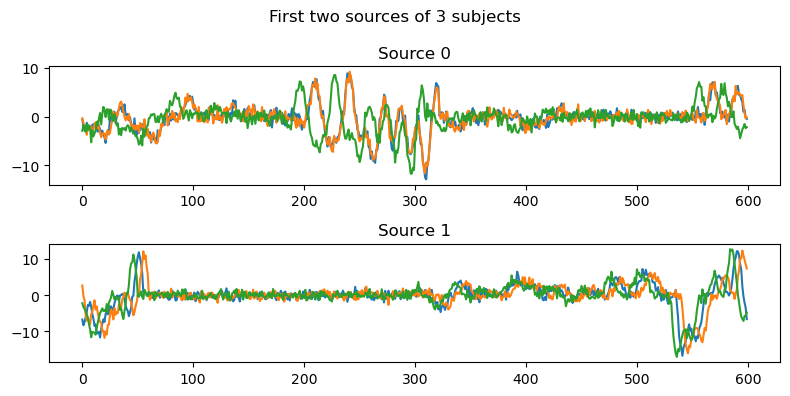

In [98]:
# plot sources of the first 2 subjects
fig, axes = plt.subplots(p, 1, figsize=(4*p, 4))

bound_min = 0
bound_max = n
for i in range(p):
    plt.subplot(p, 1, i+1)
    plt.plot(np.arange(bound_min, bound_max), S_list[:3, i, bound_min:bound_max].T)
    plt.title(f"Source {i}")
fig.suptitle("First two sources of 3 subjects")
plt.tight_layout()

In [99]:
# initialize W_list and delays
W_list_true = jnp.array([jnp.linalg.inv(A) for A in A_list])
W_list_noise = jax.random.normal(jax.random.PRNGKey(random_state), (m, p, p))
W_list_init = W_list_true + 0.1 * W_list_noise
delays_init = jnp.zeros((m, p))

# new data generation function

In [2]:
# params
m = 5
p = 2
n = 600
nb_freqs = 3
noise_data = 0.3  # noise in the generated data
noise_model = 1  # noise assumed in the model
max_dilation = 1
max_shift = 20
t0 = n / 4
random_state = 4
rng = check_random_state(random_state)

In [3]:
def apply_both_delays_1d(s, a=1, b=0, t0=0):
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a  
    # by writing (t-b)*a instead of t*a-b we allow the constant delay to be measurable in sample unit, 
    # i.e. constant_delay=5 means 5 samples, which corresponds to 5ms if the sampling rate is 1000Hz. 
    # It also means that we apply constant delay before cumulative delay, contrary to the paper on age-related delay.
    s_ab = jnp.interp(x=t_ab, xp=t, fp=s, left=0, right=0)
    return s_ab

def apply_both_delays_2d(S, a=None, b=None, t0=0):
    p, n = S.shape
    if a is None:  # if condition could cause a problem
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t, fp=S[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array(
        [apply_both_delays_2d(S_list[i], a=A[i], b=B[i], t0=t0)
         for i in range(len(S_list))])
    return Y_list

# only works for shared_delays=False
def generate_synthetic_data(
    m=2,
    p=2,
    n=100,
    nb_freqs=3,
    noise_data=0.2,
    max_dilation=1.1,
    max_shift=20,
    t0=None,
    rng=None,
):
    if rng is None:
        rng = check_random_state(0)
    # create sources
    def generate_sources(p=2, n=100, nb_freqs=3, rng=None):
        def generate_one_source(n=100, nb_freqs=3, rng=None):
            heights = rng.exponential(scale=1, size=nb_freqs) / nb_freqs
            freq_max = 6  # arbitrary
            frequencies = rng.uniform(low=1, high=freq_max, size=nb_freqs)
            t = np.linspace(0, 1, n, endpoint=False)
            s = np.zeros(n)
            for i in range(nb_freqs):
                s += heights[i] * np.sin(2 * np.pi * frequencies[i] * t)
            return s
        S = np.vstack(
            [generate_one_source(n=n, nb_freqs=nb_freqs, rng=rng)
            for _ in range(p)])
        initial_delays = rng.randint(low=0, high=n, size=p)
        S = np.roll(S, initial_delays, axis=1)
        return S
    S = generate_sources(p=p, n=n, nb_freqs=nb_freqs, rng=rng)
    # add noise
    S_list = np.array([S] * m) + noise_data * rng.randn(m, p, n)
    # mixing matrices
    A_list = rng.randn(m, p, p)
    # add delay
    dilations = rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    if t0 is None:
        t0 = n / 4
    S_list = apply_both_delays_3d(S_list, A=dilations, B=shifts, t0=t0)
    # observed signals
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

X_list, A_list, dilations, shifts, S_list, S = generate_synthetic_data(
    m=m,
    p=p,
    n=n,
    nb_freqs=nb_freqs,
    noise_data=noise_data,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    rng=rng,
)

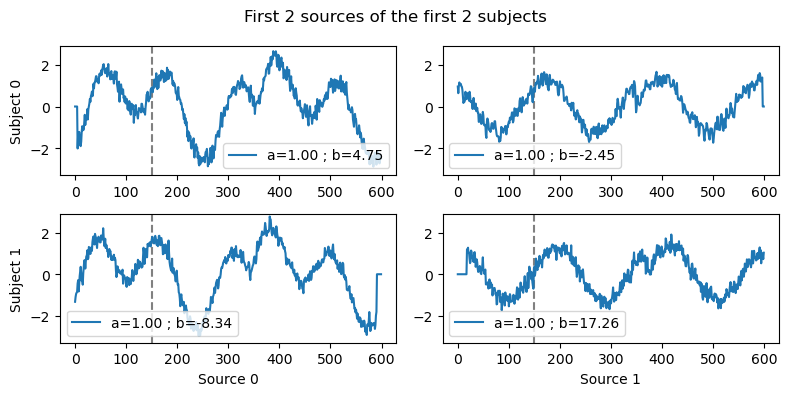

In [4]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

In [5]:
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.1 * rng.randn(m, p, p)
delays_init = jnp.zeros((m, p))

# mix of both functions

In [12]:
# only works for shared_delays=False
def soft_threshold(S, threshold=1):
    return np.sign(S) * np.maximum(0, np.abs(S) - threshold)

def generate_source_one_interval(interval_length, freqs):
    t = np.linspace(0, 6 * np.pi, interval_length)
    s = np.sum([np.sin(f * t) for f in freqs], axis=0)
    return s

def generate_one_source(interval_length, freqs, power):
    s = np.array([p * generate_source_one_interval(interval_length, freqs[i, :]) for p, i in zip(power, range(len(power)))]).reshape(-1)
    return s

def generate_sources(p, n, nb_intervals=5, nb_freqs=20, rng=None):
    rng = check_random_state(random_state)
    interval_length = n // nb_intervals
    freqs = rng.randn(p, nb_intervals, nb_freqs)
    power = rng.exponential(size=(p, nb_intervals))
    S = np.array([generate_one_source(interval_length, freqs[i], power[i]) for i in range(p)])
    shifts = (rng.rand(p) * n).astype("int")
    S = np.array([np.roll(S[i], shift) for i, shift in enumerate(shifts)])
    return S

def gen_data(
    m,
    p,
    n,
    nb_intervals=5,
    nb_freqs=20,
    threshold=1,
    max_dilation=1.1,
    max_shift=20,
    t0=0,
    noise=0.05,
    rng=None,
):
    if rng is None:
        rng = check_random_state(0)
    A_list = rng.randn(m, p, p)
    S = generate_sources(p, n, nb_intervals, nb_freqs, rng)
    S = soft_threshold(S, threshold=threshold)
    noise_list = noise * rng.randn(m, p, n)
    S_list = np.array([S + N for N in noise_list])
    # add delays
    dilations = rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    S_list = apply_both_delays_3d(S_list, A=dilations, B=shifts, t0=t0)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

In [16]:
# params
m = 5
p = 2
n = 600
nb_intervals = 5
nb_freqs = 10
threshold = 1
max_dilation = 1.
max_shift = 20
t0 = 0
noise_data = 0.8
noise_model = 1
random_state = 42
rng = check_random_state(random_state)

In [17]:
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise=noise_data,
    rng=rng,
)

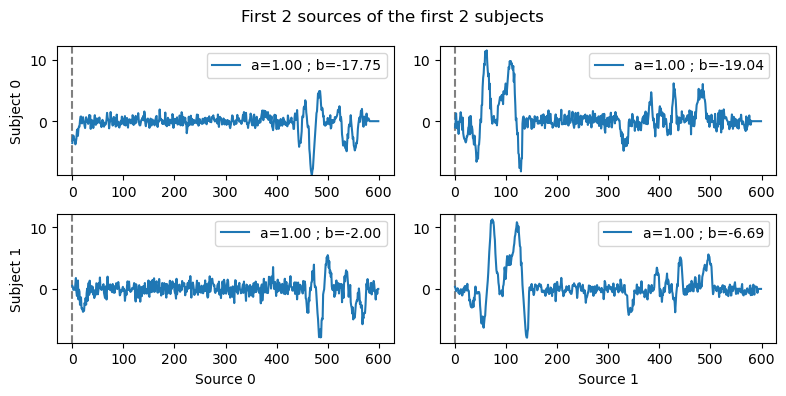

In [18]:
# plot 2 sources of 2 subjects
plt.subplots(2, 2, figsize=(8, 4))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

In [22]:
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.1 * rng.randn(m, p, p)
delays_init = jnp.zeros((m, p))

# loss function

In [6]:
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

# only works for shared_delays=False
def loss_function(W_delays, X_list, noise):
    m, p, n = X_list.shape
    W_list, delays = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:].reshape((m, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = _apply_continuous_delays(
        S_list=S_list,
        tau_list=-delays,
        shared_delays=False,
        multiple_subjects=True,
        use_jax=True,
    )
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

In [7]:
wrapper_loss = jax.jit(loss_function)

val_and_grad = jax.jit(jax.value_and_grad(loss_function))

def wrapper_grad(W_delays, X_list, noise):
    _, grad = val_and_grad(W_delays, X_list, noise)
    return np.array(grad)

In [8]:
W_delays = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(delays_init)])

In [9]:
start = time()
wrapper_loss(W_delays, X_list, noise_model)
wrapper_grad(W_delays, X_list, noise_model)
print(f"time : {time() - start}")

time : 7.745487451553345


# fmin_bfgs

In [10]:
fmin_bfgs_res = fmin_bfgs(wrapper_loss, x0=W_delays, args=(X_list, noise_model), fprime=wrapper_grad)
W_fmin_bfgs, shifts_fmin_bfgs = fmin_bfgs_res[:m*p**2].reshape((m, p, p)), fmin_bfgs_res[m*p**2:].reshape((m, p))

         Current function value: -10.716917
         Iterations: 156
         Function evaluations: 236
         Gradient evaluations: 235


Too long: I should maybe use value_and_grad instead of grad.

# plot

In [11]:
# estimated sources are not necessarily in the same order as true sources
def find_order(S1, S2):
    S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)
    S2 = S2 / np.linalg.norm(S2, axis=1, keepdims=True)
    M = np.abs(np.dot(S1, S2.T))
    try:
        _, order = scipy.optimize.linear_sum_assignment(-abs(M))
    except:
        order = np.arange(p)
    return order

# compute Y_avg
S_list_fmin_bfgs = np.array([np.dot(W, X) for W, X in zip(W_fmin_bfgs, X_list)])
Y_list_fmin_bfgs = _apply_continuous_delays(
    S_list=S_list_fmin_bfgs,
    tau_list=-shifts_fmin_bfgs,
    shared_delays=False,
    multiple_subjects=True,
    use_jax=True,
)
Y_fmin_bfgs = np.mean(Y_list_fmin_bfgs, axis=0)

# change sources order
order_fmin_bfgs = find_order(S, Y_fmin_bfgs)
shifts_fmin_bfgs = shifts_fmin_bfgs[:, order_fmin_bfgs]

# normalize
shifts_fmin_bfgs_norm = shifts_fmin_bfgs - np.mean(shifts_fmin_bfgs, axis=0)
shifts_norm = shifts - np.mean(shifts, axis=0)

In [12]:
shifts

array([[  4.75192122,  -2.45488813],
       [ -8.33869479,  17.25502139],
       [  8.1377502 , -15.4294049 ],
       [ -8.29987203,  -4.81954545],
       [ -2.72070406, -13.04565262]])

In [13]:
shifts_fmin_bfgs

DeviceArray([[  5.1976485 ,   0.4999684 ],
             [ -6.0482054 ,  19.99159   ],
             [  7.5442777 , -12.074472  ],
             [ -6.0324373 ,  -1.4915061 ],
             [ -0.40921503,  -9.550844  ]], dtype=float32)

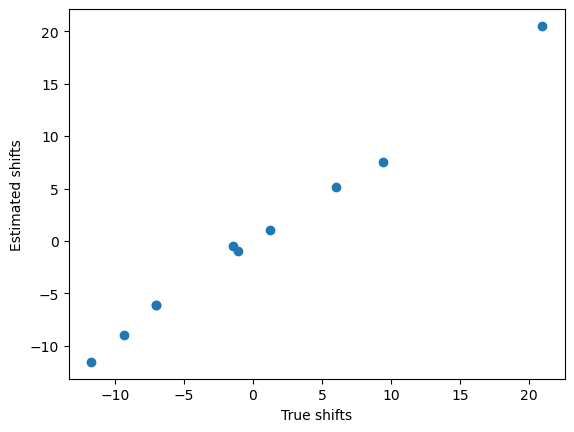

In [14]:
plt.scatter(shifts_norm, shifts_fmin_bfgs_norm)
plt.xlabel("True shifts")
plt.ylabel("Estimated shifts")
plt.show()

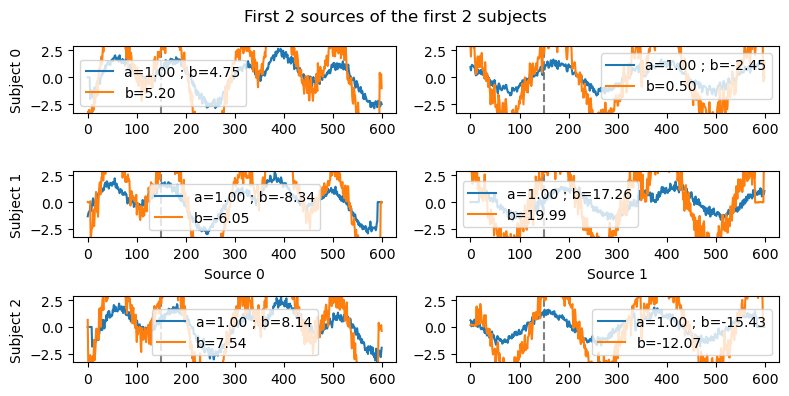

In [15]:
# plot 2 sources of 2 subjects
plt.subplots(3, 2, figsize=(8, 4))

for i in range(3):
    for j in range(2):
        plt.subplot(3, 2, 2 * i + j + 1)
        plt.plot(S_list[i, j], label=f'a={dilations[i, j]:.2f} ; b={shifts[i, j]:.2f}')
        plt.plot(Y_list_fmin_bfgs[i, j], label=f'b={shifts_fmin_bfgs[i, j]:.2f}')
        plt.vlines(x=t0, ymin=np.min(S_list), ymax=np.max(S_list), linestyles='--', colors='grey')
        plt.ylim([np.min(S_list), np.max(S_list)])
        if j == 0:
            plt.ylabel(f"Subject {i}")
        if i == 1:
            plt.xlabel(f"Source {j}")
        plt.legend()
plt.suptitle(f"First 2 sources of the first 2 subjects")
plt.tight_layout()
plt.show()

# multiple seeds

In [ ]:
def run_experiment(random_state):
    